***TrashNet AI***

1. Imports y configuración inicial

In [3]:
# Importación de bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import kagglehub
from PIL import Image
from tensorflow.keras.utils import Sequence

# Configuración inicial
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 15
LEARNING_RATE = 0.001
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Configuración de paths según estructura CookieCutter
try:
    # Esto funciona cuando se ejecuta como script
    PROJECT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    # Esto funciona en notebooks o consola interactiva
    PROJECT_DIR = os.getcwd()  # Usa el directorio de trabajo actual

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')

# Crear directorios si no existen
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Clase generadora personalizada para manejar grandes datasets
class WasteImageGenerator(Sequence):
    def __init__(self, image_paths, labels, label_names, batch_size, img_size, augment=False):
        super().__init__()  # Inicializa la clase padre Sequence
        self.image_paths = image_paths
        self.labels = labels
        self.label_names = label_names
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.num_classes = len(label_names)

        if augment:
            self.datagen = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_images = []
        for img_path in batch_paths:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(self.img_size)
            img_array = np.array(img) / 255.0
            batch_images.append(img_array)

        batch_images = np.array(batch_images)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        if self.augment:
            batch_images = next(self.datagen.flow(batch_images, shuffle=False))

        return batch_images, batch_labels

# Descarga del dataset usando kagglehub
print("Descargando dataset...")
download_dir = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Dataset descargado en:", download_dir)

# Buscar imágenes y etiquetas recursivamente
image_paths = []
labels = []
label_names = []

for root, dirs, files in os.walk(download_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Extraer etiqueta del path (asumiendo estructura categoria/imagen)
            label = os.path.basename(root)

            if label not in label_names:
                label_names.append(label)

            label_idx = label_names.index(label)

            image_paths.append(os.path.join(root, file))
            labels.append(label_idx)

if not image_paths:
    raise FileNotFoundError("No se encontraron imágenes en el dataset descargado")

print(f"\nEncontradas {len(image_paths)} imágenes en total")
print("Clases encontradas:", label_names)

# Dividir índices en train, val, test
indices = np.arange(len(image_paths))
train_idx, test_idx = train_test_split(indices, test_size=TEST_SIZE, stratify=labels, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=VAL_SIZE/(1-TEST_SIZE), stratify=np.array(labels)[train_idx], random_state=42)

# Crear generadores
train_generator = WasteImageGenerator(
    np.array(image_paths)[train_idx].tolist(),
    np.array(labels)[train_idx].tolist(),
    label_names,
    BATCH_SIZE,
    IMG_SIZE,
    augment=True)

val_generator = WasteImageGenerator(
    np.array(image_paths)[val_idx].tolist(),
    np.array(labels)[val_idx].tolist(),
    label_names,
    BATCH_SIZE,
    IMG_SIZE)

test_generator = WasteImageGenerator(
    np.array(image_paths)[test_idx].tolist(),
    np.array(labels)[test_idx].tolist(),
    label_names,
    BATCH_SIZE,
    IMG_SIZE)

print("\nDivisión final:")
print(f"Train: {len(train_idx)} muestras")
print(f"Validation: {len(val_idx)} muestras")
print(f"Test: {len(test_idx)} muestras")

# Guardar metadatos y paths en processed data
metadata = {
    'image_paths': image_paths,
    'labels': labels,
    'label_names': label_names,
    'train_idx': train_idx.tolist(),
    'val_idx': val_idx.tolist(),
    'test_idx': test_idx.tolist()
}

metadata_path = os.path.join(PROCESSED_DATA_DIR, 'metadata.pkl')
pd.to_pickle(metadata, metadata_path)
print(f"\nMetadatos guardados en: {metadata_path}")

Descargando dataset...
Dataset descargado en: C:\Users\Nicolás Molina\.cache\kagglehub\datasets\alistairking\recyclable-and-household-waste-classification\versions\1

Encontradas 15000 imágenes en total
Clases encontradas: ['default', 'real_world']

División final:
Train: 9000 muestras
Validation: 3000 muestras
Test: 3000 muestras

Metadatos guardados en: E:\TrashNet AI\TrashNet AI\notebooks\data\processed\metadata.pkl


Implementación del modelo y entrenamiento.

In [4]:
# Modelo CNN optimizado para memoria
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),  # Reducido para ahorrar memoria
    layers.BatchNormalization(),
    layers.Dense(len(label_names), activation='softmax')
])

# Compilación
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_waste_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks,
    verbose=1)


C:\Users\Nicolás Molina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


KeyboardInterrupt: 

Evaluación y visualización.


Evaluando en conjunto de prueba...
94/94 ━━━━━━━━━━━━━━━━━━━━ 36s 379ms/step - accuracy: 0.5647 - loss: 0.6917 - precision: 0.5647 - recall: 0.5647

Resultados en conjunto de prueba:
Loss: 0.6905
Accuracy: 0.5650
Precision: 0.5650
Recall: 0.5650

Modelo guardado como 'waste_classifier_final.h5'


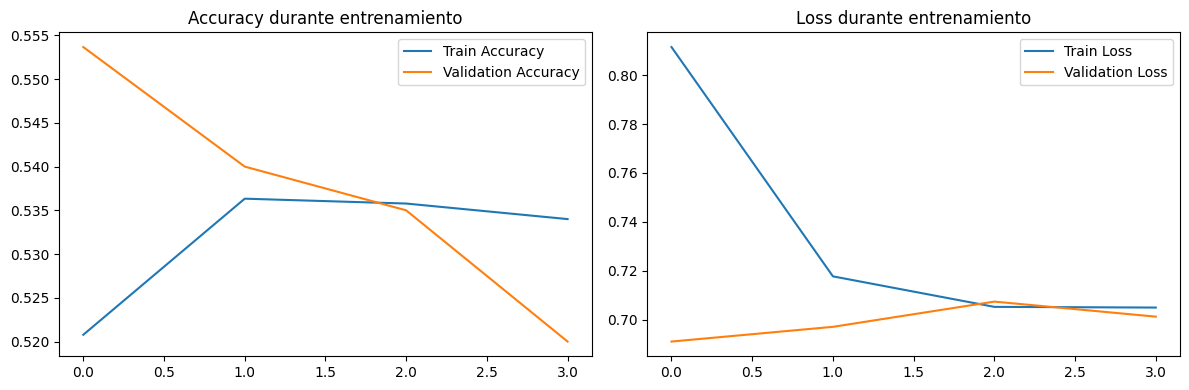

In [18]:
# Evaluación
print("\nEvaluando en conjunto de prueba...")
test_results = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

print("\nResultados en conjunto de prueba:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

# Generar predicciones para la matriz de confusión
print("\nGenerando predicciones para matriz de confusión...")
y_true = []
y_pred = []

# Iterar por el generador de prueba para obtener todas las predicciones
for i in range(len(test_generator)):
    if (i+1) % 10 == 0:
        print(f"Procesando batch {i+1}/{len(test_generator)}")
    x, y = test_generator[i]
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calcular métricas por clase
print("\nMétricas por clase:")
class_report = classification_report(y_true, y_pred, target_names=label_names)
print(class_report)

# Guardar modelo
model.save('waste_classifier_final.keras')
print("\nModelo guardado como 'waste_classifier_final.h5'")

# Visualización
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()